In [1]:
import numpy as np
import pandas as pd
import keras

Using TensorFlow backend.


In [2]:
ANNOTATIONS_DIR = '../data/annotations/annotations averaged per song/song_level'
MFCC_DIR = '../data/mfcc'
METADATA_DIR = '../data/metadata'

df = pd.read_csv(f"{ANNOTATIONS_DIR}/static_annotations_averaged_songs_1_2000.csv", index_col='song_id')
print(df.shape)
df2 = pd.read_csv(f"{ANNOTATIONS_DIR}/static_annotations_averaged_songs_2000_2058.csv", index_col='song_id')
print(df2.shape)
for column in df2.columns.values:
   if column not in df.columns.values:
       df2 = df2.drop(column, axis = 1)
print(df2.shape)
df = df.append(df2)
print(df.values.shape)
song_ids = df.index.tolist()
print(len(song_ids))

(1744, 4)
(58, 12)
(58, 4)
(1802, 4)
1802


In [3]:
X = []
for song in song_ids:
    mfcc_df = pd.read_csv(f"{MFCC_DIR}/{song}.csv", header=None, index_col=0)
    song_mfcc = []
    for i in range(0,45,2):
        temp = mfcc_df.loc[i,1]
        temp = temp.replace('[', '')
        temp = temp.replace(']', '')
        temp = temp.replace('\n', '')
        song_mfcc_temp = [float(s) for s in temp.split()]
        song_mfcc.append(song_mfcc_temp)
    X.append(song_mfcc)
X = np.array(X)
X.shape

(1802, 23, 14)

In [4]:
y = []
for song in song_ids:
    y.append([df.loc[song].values[0], df.loc[song].values[2]])
y = np.array(y)
y.shape

(1802, 2)

In [10]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense
from keras.optimizers import Adam

def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

input_shape = (X.shape[1], X.shape[2])
model = Sequential()
model.add(LSTM(32, input_shape=input_shape, dropout=0.05, recurrent_dropout=0.35))
model.add(Dense(1))

model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['acc', 'mae', coeff_determination])
history = model.fit(X, y[:, 0],
                    epochs=40,
                    batch_size=128,
                    validation_split=0.2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1441 samples, validate on 361 samples
Epoch 1/40
1441/1441 [==============================] - 1s 634us/step - loss: 26.5874 - acc: 0.0000e+00 - mean_absolute_error: 4.9694 - coeff_determination: -17.2503 - val_loss: 21.2741 - val_acc: 0.0000e+00 - val_mean_absolute_error: 4.4945 - val_coeff_determination: -21.5732
Epoch 2/40
1441/1441 [==============================] - 0s 196us/step - loss: 20.3764 - acc: 0.0000e+00 - mean_absolute_error: 4.2802 - coeff_determination: -13.0321 - val_loss: 14.7972 - val_acc: 0.0000e+00 - val_mean_absolute_error: 3.7084 - val_coeff_determination: -14.7105
Epoch 3/40
1441/1441 [==============================] - 0s 218us/step - loss: 15.2054 - acc: 0.0000e+00 - mean_absolute_error: 3.6054 - coeff_determination: -9.47

1441/1441 [==============================] - 0s 156us/step - loss: 1.1453 - acc: 0.0312 - mean_absolute_error: 0.8554 - coeff_determination: 0.2175 - val_loss: 1.0919 - val_acc: 0.0360 - val_mean_absolute_error: 0.8141 - val_coeff_determination: -0.0993
Epoch 29/40
1441/1441 [==============================] - 0s 154us/step - loss: 1.1230 - acc: 0.0347 - mean_absolute_error: 0.8510 - coeff_determination: 0.2266 - val_loss: 1.0802 - val_acc: 0.0388 - val_mean_absolute_error: 0.8092 - val_coeff_determination: -0.0871
Epoch 30/40
1441/1441 [==============================] - 0s 155us/step - loss: 1.1739 - acc: 0.0285 - mean_absolute_error: 0.8687 - coeff_determination: 0.1960 - val_loss: 1.0868 - val_acc: 0.0360 - val_mean_absolute_error: 0.8094 - val_coeff_determination: -0.0932
Epoch 31/40
1441/1441 [==============================] - 0s 156us/step - loss: 1.1379 - acc: 0.0340 - mean_absolute_error: 0.8504 - coeff_determination: 0.2191 - val_loss: 1.0861 - val_acc: 0.0332 - val_mean_absolu

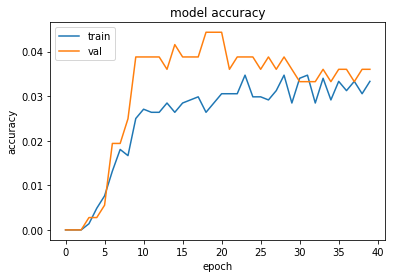

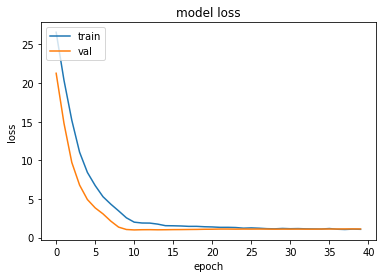

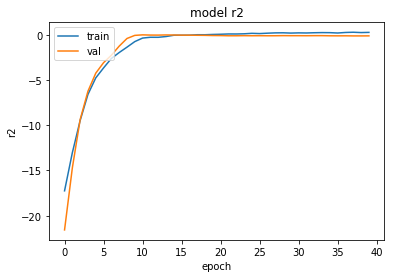

In [12]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for r2
plt.plot(history.history['coeff_determination'])
plt.plot(history.history['val_coeff_determination'])
plt.title('model r2')
plt.ylabel('r2')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()